In [10]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_percentage_error

import optuna
import matplotlib.pyplot as plt
import japanize_matplotlib

# メーカーデータの足切り

In [11]:
#データの読み込み
train_data = pd.read_csv("../data/機械学習用/train_data.csv",index_col=0)
model_data = pd.read_csv('../data/アップロード用/model_data.csv',index_col=0)
info_data = pd.read_csv('../data/アップロード用/bike_info.csv',index_col=0)
#サンプルサイズが少ないモデルを抽出
all_data = info_data.merge(model_data,on='model_number',how='left')
brand_count = all_data.groupby('brand').size().sort_values(ascending=True)
#下位10メーカーを抽出(上のcountデータがすでに照準のため上から９つを抽出する)
low_10 = brand_count.index[0:10]
model_data = model_data[~model_data['brand'].isin(low_10)]
#このメーカーデータを使ってtrainデータに結合
train_data = train_data.merge(model_data,on='model_number',how='left')
#先ほど外れ値に指定したデータはnullになるため、dropnaをすればok
train_data.dropna(inplace=True)

# モデルの作成  
使用する特徴量  
* model_year
* color
* mileage 
* gurantee_period
* brand
* type
* displacement  
今回、最終的にはwebアプリ化を目標としているためstore_idは削除,model_number,nameはデータがないバイクが予測時に取り扱えなくなるので削除した

In [12]:
#dummyエンコーディング
encoding_target = ['color','brand','type']
#エンコーディングしたい列
train_data=pd.get_dummies(train_data,drop_first=True,columns=encoding_target)

In [13]:
#説明変数と目的変数の抽出
X = train_data.iloc[:,2:].drop(columns=['model_number','name','store_id']).values
y = train_data['cost'].values
#学習データと検証データへの分割
X_learn,X_val,y_learn,y_val = train_test_split(X,y,test_size=0.2,random_state=123)

# OptunaとCVを組み合わせたパラメータチューニング

# MAPEを指標としたモデルのチューニング

In [14]:
def objective(trial):
    model = RandomForestRegressor(random_state=0)
    params = {
        'bootstrap':trial.suggest_categorical('bootstrap',[True,False]),
        'max_depth':trial.suggest_int('max_depth',1,100),
        'max_features':trial.suggest_float('max_features',0,1.0),
        'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',1,1000),
        'n_estimators':trial.suggest_int('n_estimators',1,1000),
        'min_samples_split':trial.suggest_int('min_samples_split',2,5),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10)
    }
    reg_model=model.set_params(**params)

    #スコアをcross_val_scoreにする(cv=5,scoring=r2_score)
    score = cross_val_score(reg_model,X_learn,y_learn,cv=5,scoring='neg_mean_absolute_percentage_error',n_jobs=-1)

    mape = score.mean()

    return mape

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=100)

[I 2023-11-29 14:27:16,465] A new study created in memory with name: no-name-9b95523c-48db-4206-9dbd-62cf81d4100e
[I 2023-11-29 14:27:17,384] Trial 0 finished with value: -0.322316622340976 and parameters: {'bootstrap': True, 'max_depth': 31, 'max_features': 0.3633150954429982, 'max_leaf_nodes': 17, 'n_estimators': 131, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: -0.322316622340976.
[I 2023-11-29 14:27:18,260] Trial 1 finished with value: -0.18233001325686285 and parameters: {'bootstrap': True, 'max_depth': 39, 'max_features': 0.30847358234185807, 'max_leaf_nodes': 392, 'n_estimators': 305, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: -0.18233001325686285.
[I 2023-11-29 14:27:18,795] Trial 2 finished with value: -0.1635621821392801 and parameters: {'bootstrap': True, 'max_depth': 26, 'max_features': 0.5320588840066707, 'max_leaf_nodes': 525, 'n_estimators': 91, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 2

In [16]:
best_params=study.best_params
best_params

{'bootstrap': False,
 'max_depth': 34,
 'max_features': 0.5967285924743135,
 'max_leaf_nodes': 751,
 'n_estimators': 85,
 'min_samples_split': 3,
 'min_samples_leaf': 2}

In [17]:
study.best_value

-0.14093549628832405

# チューニングしたモデルの実装

In [34]:
rf = RandomForestRegressor(random_state=0)
rf.set_params(**best_params)
rf.fit(X_learn,y_learn)

RandomForestRegressor(bootstrap=False, max_depth=72,
                      max_features=0.4889059791965009, max_leaf_nodes=892,
                      min_samples_split=4, n_estimators=777, random_state=0)

In [35]:
predict_learn = rf.predict(X_learn)
predict_val = rf.predict(X_val)
print('学習データMAPE',mean_absolute_percentage_error(y_pred=predict_learn,y_true=y_learn))
print('検証データMAPE',mean_absolute_percentage_error(y_pred=predict_val,y_true=y_val))
print('学習データr_2',rf.score(X_learn,y_learn))
print('検証データr_2',rf.score(X_val,y_val))

学習データMAPE 0.06101379676393758
検証データMAPE 0.14580343707788773
学習データr_2 0.9896892515317378
検証データr_2 0.8147208251845144


In [36]:
rf.score(X_val,y_val)

0.8147208251845144

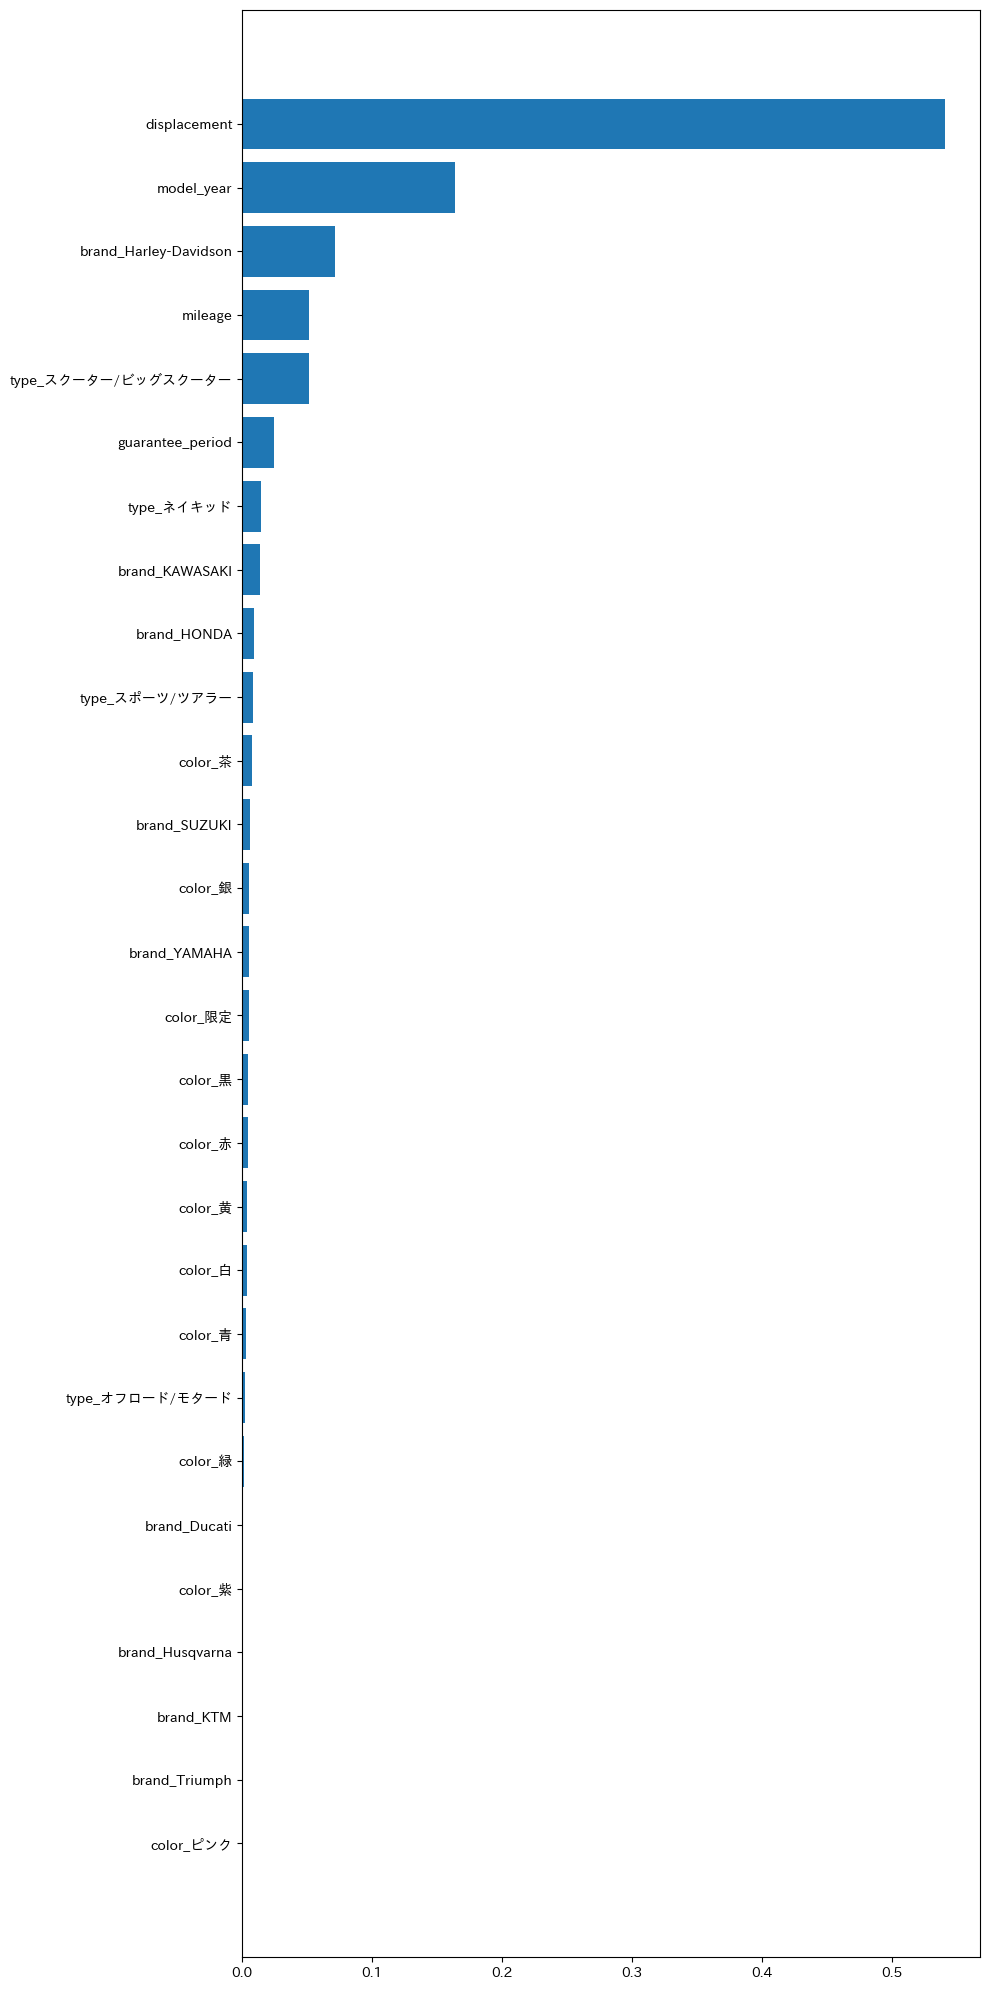

In [37]:
#feature_importanceも確認してみる
plt.subplots(figsize=(10,20))
featuer_name = train_data.drop(columns=['id','cost','model_number','name','store_id']).columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.barh(np.asarray(featuer_name)[indices],importances[indices])
plt.tight_layout()
plt.show()

# 残差プロットを作成

In [38]:
y_learn_pred = rf.predict(X_learn)
y_val_pred = rf.predict(X_val)

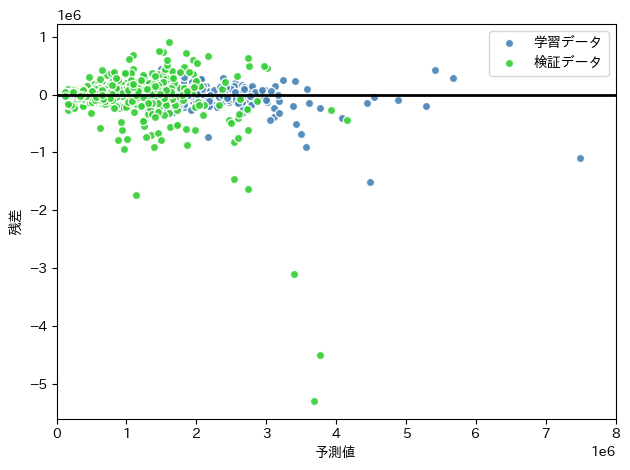

In [39]:
plt.scatter(y_learn_pred,
            y_learn_pred - y_learn,
            c='steelblue',
            edgecolors='white',
            marker='o',
            s=35,
            alpha=0.9,
            label = '学習データ')
plt.scatter(y_val_pred,
            y_val_pred - y_val,
            c='limegreen',
            edgecolors='white',
            marker='o',
            s=35,
            alpha=0.9,
            label ='検証データ')
plt.xlabel('予測値')
plt.ylabel('残差')
plt.legend()
plt.hlines(y=0,xmin=-10,xmax=8*10**6,lw=2,colors='black')
plt.xlim([-10,8*10**6])
plt.tight_layout()
plt.show()

# テストデータ検証

In [48]:
test_data = pd.read_csv('../data/機械学習用/test_data.csv',index_col=0)
test_data=test_data.merge(model_data,on='model_number',how='left')
test_data.dropna(inplace=True)
#ダミー変数化
#dummyエンコーディング
encoding_target = ['color','brand','type']
#エンコーディングしたい列
test_data=pd.get_dummies(test_data,drop_first=True,columns=encoding_target)
X_test=test_data.iloc[:,2:].drop(columns=['name','model_number','store_id']).values
y_test = test_data['cost'].values

In [49]:
rf_test = RandomForestRegressor(random_state=0)
rf_test.set_params(**best_params)
rf_test.fit(X,y)
predict_train = rf_test.predict(X)
predict_test = rf_test.predict(X_test)
print('訓練データ決定係数',r2_score(y_true=y,y_pred=predict_train))
print('テストデータ決定係数',r2_score(y_true=y_test,y_pred=predict_test))
print('訓練データMAPE',mean_absolute_percentage_error(y_true=y,y_pred=predict_train))
print('テストデータMAPE',mean_absolute_percentage_error(y_true=y_test,y_pred=predict_test))

訓練データ決定係数 0.9853985841648546
テストデータ決定係数 0.8024717462908885
訓練データMAPE 0.07119455889801628
テストデータMAPE 0.14617753687942753


## RandomForestによる予測がMAPEが最小,R^2スコアが最大となった